# Composing Losses with captum.optim

This notebook demonstrates how the loss functions in `captum.optim.loss` can be modified or combined to create interesting results.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from torchvision.models import alexnet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = alexnet(pretrained=True).to(device)

In [2]:
# Helper function for visualization
def visualize(model, image, loss_fn, lr=0.025):
    transforms = torch.nn.Sequential(
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        torch.nn.ReflectionPad2d(16),
        opt.transform.RandomSpatialJitter(16),
        opt.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        opt.transform.RandomSpatialJitter(8),
        opt.transform.CenterCrop((224,224)),
    )
    obj = opt.InputOptimization(model, loss_fn, image, transforms, lr=lr)
    history = obj.optimize(opt.optimization.n_steps(128))
    image().show()

## Negative Channel Visualizations

With interpretability via optimization, we can visualize "extremely positive examples" that maximize activations in the positive direction.

Equally informative are "extremely negative examples" that we can visualize by simply negating the loss function. These examples maximize the activations in the opposite direction and as we will see, the visualizations are often semantically opposite as well.

We do this by initializing an image of batch 2 and then indicating the appropriate `batch_index` when initializing the loss functions. To combine the loss functions, we can simply sum up the losses.

In this example, we see that the original loss function (left) gives us a black and white image with vertical-ish patterns. With the negated loss function (right), we get a colored image that has subtle horizontal patterns. 

  0%|          | 0/128 [00:00<?, ? step/s]

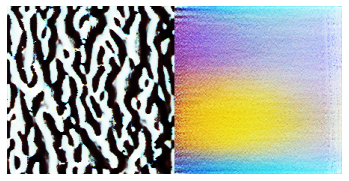

In [3]:
# Generate a visualization where the left and right images
# optimize losses in opposite directions.
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[1], 5, batch_index=0),
    -opt.loss.ChannelActivation(model.features[1], 5, batch_index=1),
])
visualize(model, image, loss_fn)

In this other example, we see that this channel is activated by circular overlapping curves (left), while the negated loss function gives us straight overlapping angles (right).

  0%|          | 0/128 [00:00<?, ? step/s]

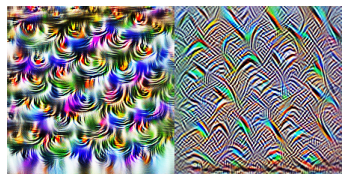

In [4]:
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[6], 0, batch_index=0),
    -opt.loss.ChannelActivation(model.features[6], 0, batch_index=1),
])
visualize(model, image, loss_fn)

As we go deeper, the negated loss functions may be less semantically meaningful, although we may still see contrasting features such as rigid angles (left) versus flowing curves (right).

  0%|          | 0/128 [00:00<?, ? step/s]

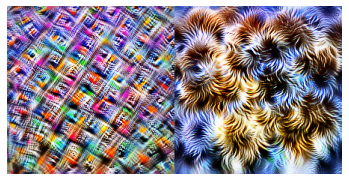

In [5]:
image = opt.images.NaturalImage((224, 224), batch=2).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[10], 1, batch_index=0),
    -opt.loss.ChannelActivation(model.features[10], 1, batch_index=1),
])
visualize(model, image, loss_fn)

## Combining Losses

We can also combine losses which will intuitively result in combinations of visualizations.

For example, we can combine a channel that activates on black and white stripes with a channel that activates on a furry texture, to create a visualization that mixes the two.

Similar to the previous section, we do this by first initializing an image of batch 3 and specify the appropriate `batch_index` when declaring the losses. Finally, sum up all of the losses.

  0%|          | 0/128 [00:00<?, ? step/s]

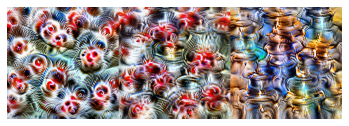

In [6]:
# Generate a visualization where the middle image is a combination
# of the left and right.
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[10], 0, batch_index=0),
    opt.loss.ChannelActivation(model.features[10], 0, batch_index=1),
    opt.loss.ChannelActivation(model.features[10], 2, batch_index=1),
    opt.loss.ChannelActivation(model.features[10], 2, batch_index=2),
])
visualize(model, image, loss_fn)

We can also combine losses from different layers. However, note that when mixing activations from different layers, we sometimes have to scale the loss functions appropriately. Specifically, we may need to scale up the earlier layers, since the magnitude of the loss may be smaller.

  0%|          | 0/128 [00:00<?, ? step/s]

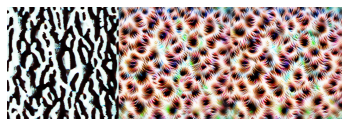

In [7]:
# Without scaling, the output is overwhelmed by the later layer
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[1], 5, 0),
    opt.loss.ChannelActivation(model.features[1], 5, 1), 
    opt.loss.ChannelActivation(model.features[9], 8, 1),
    opt.loss.ChannelActivation(model.features[9], 8, 2),
])
visualize(model, image, loss_fn)

  0%|          | 0/128 [00:00<?, ? step/s]

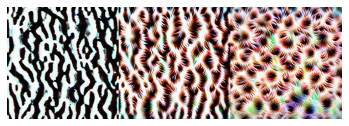

In [8]:
# With appropriate scaling, we get a balanced mix.
image = opt.images.NaturalImage((224, 224), batch=3).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.features[1], 5, 0),
    # Scale up loss of earlier layer
    25*opt.loss.ChannelActivation(model.features[1], 5, 1), 
    opt.loss.ChannelActivation(model.features[9], 8, 1),
    opt.loss.ChannelActivation(model.features[9], 8, 2),
])
visualize(model, image, loss_fn)